### Prétraitement d'image

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# On ouvre l'image "Torse"
original_Im = cv2.imread('000118 (4).png',0)

# Application d'un équalisateur d'histogramme
# Il redonne via une formule mathématique une valeur pour chaque pixel afin d'utiliser l'ensemble des valeurs de pixel de manière la plus équitable possible
equi_Im = cv2.equalizeHist(original_Im)

# Application d'un CLAHE
# Contrast Limited Adaptive Histogram Equalization (CLAHE) : l'image est divisés en blocs sur lequels une équalisation d'histogramme est effectué.
# Une limite de contrast est aussi définie. Si une case de l'histogramme dépasse le valeur limite alors les valeurs en excès sont accumulées et redistribuées dans d'autres cases
clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(16,16))
cl1 = clahe.apply(original_Im)

## Segmentation supervisé
### Active Contour Segmentation

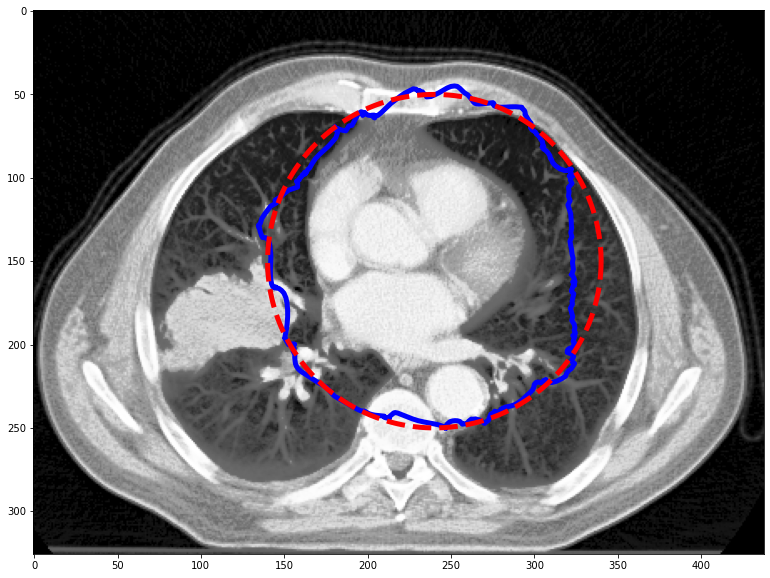

In [4]:
# Importing necessary libraries
from skimage.color import rgb2gray
# from skimage.filters import gaussian
from skimage.segmentation import active_contour

# Sample Image of scikit-image package
# astronaut = data.astronaut()
#gray_equi_Im = rgb2gray(equi_Im)

# Applying Gaussian Filter to remove noise
# gray_astronaut_noiseless = gaussian(gray_astronaut, 1)

# Localising the circle's center at 240, 150
x1 = 240 + 100*np.cos(np.linspace(0, 2*np.pi, 500))
x2 = 150 + 100*np.sin(np.linspace(0, 2*np.pi, 500))

# Generating a circle based on x1, x2
snake = np.array([x1, x2]).T

# Computing the Active Contour for the given image
CTadenoma_snake = active_contour(equi_Im,
								snake)

fig = plt.figure(figsize=(20, 10))

# Adding subplots to display the markers
ax = fig.add_subplot(111)

# Plotting sample image
ax.imshow(equi_Im, cmap='gray')

# Plotting the face boundary marker
ax.plot(CTadenoma_snake[:, 0],
		CTadenoma_snake[:, 1],
		'-b', lw=5)

# Plotting the circle around face
ax.plot(snake[:, 0], snake[:, 1], '--r', lw=5)


### Thresholding

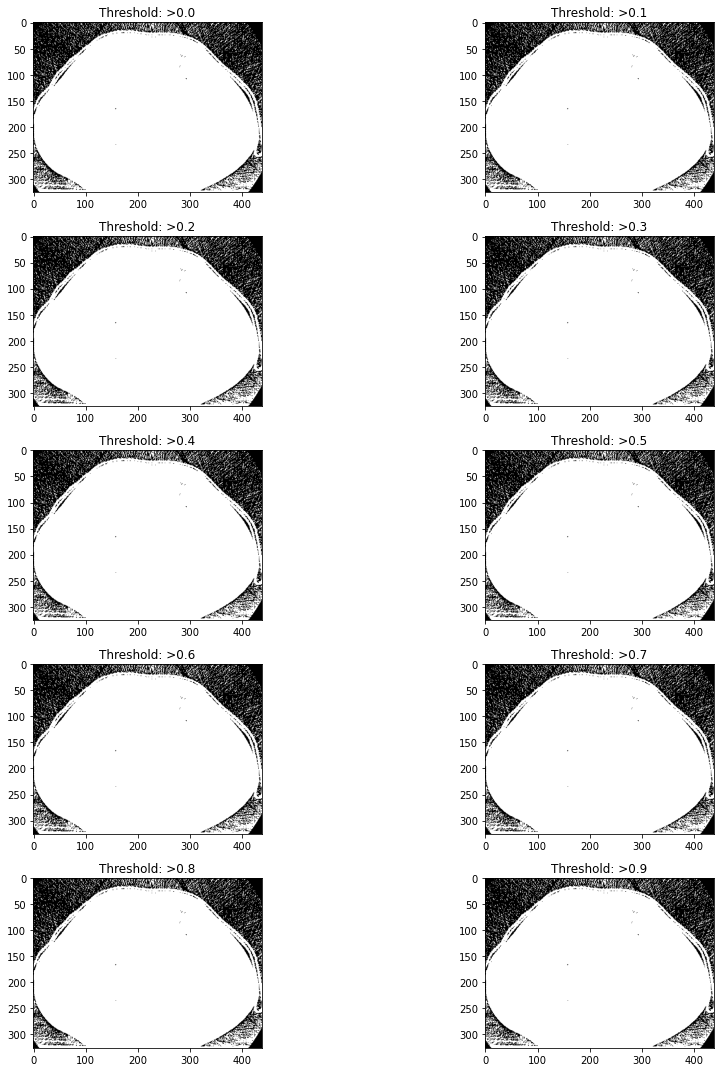

In [5]:
# Setting the plot size to 15,15
plt.figure(figsize=(15, 15))
 
for i in range(10):
   
  # Iterating different thresholds
  binarized_gray = (equi_Im > i*0.1)*1
  plt.subplot(5,2,i+1)
   
  # Rounding of the threshold
  # value to 1 decimal point
  plt.title("Threshold: >"+str(round(i*0.1,1)))
   
  # Displaying the binarized image
  # of various thresholds
  plt.imshow(binarized_gray, cmap = 'gray')
   
plt.tight_layout()

## Segmentation non supervisé
### Mark Boundaries

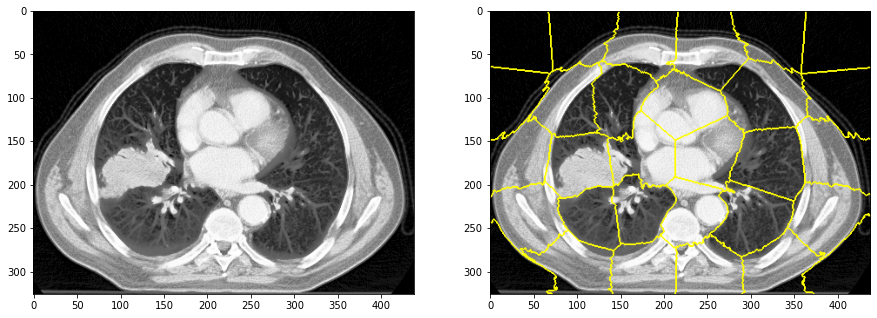

In [12]:
# Importing required boundaries
from skimage.segmentation import slic, mark_boundaries

# Setting the plot figure as 15, 15
plt.figure(figsize=(15, 15))

# Applying SLIC segmentation
# for the edges to be drawn over
CT_adenoma_segments = slic(equi_Im,
						n_segments=30,
						compactness=1)

plt.subplot(1, 2, 1)

# Plotting the original image
plt.imshow(equi_Im, cmap = 'gray')

# Detecting boundaries for labels
plt.subplot(1, 2, 2)

# Plotting the output of marked_boundaries
# function i.e. the image with segmented boundaries
plt.imshow(mark_boundaries(equi_Im, CT_adenoma_segments))
